In [2]:
# Install OS dependencies.  This only needs to be run once for each new notebook instance.
!pip install PyAthena

In [3]:
from pyathena import connect
from pyathena.util import as_pandas
from __future__ import print_function

# Import libraries
import datetime
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import os
import boto3
from botocore.client import ClientError
# below is used to print out pretty pandas dataframes
from IPython.display import display, HTML
%matplotlib inline


s3 = boto3.resource('s3')
client = boto3.client("sts")
account_id = client.get_caller_identity()["Account"]
my_session = boto3.session.Session()
region = my_session.region_name
athena_query_results_bucket = 'aws-athena-query-results-'+account_id+'-'+region

try:
    s3.meta.client.head_bucket(Bucket=athena_query_results_bucket)
except ClientError:
    bucket = s3.create_bucket(Bucket=athena_query_results_bucket)
    print('Creating bucket '+athena_query_results_bucket)
cursor = connect(s3_staging_dir='s3://'+athena_query_results_bucket+'/athena/temp').cursor()


# The Glue database name of your MIMIC-III parquet data
gluedatabase="mimiciii"

# location of the queries to generate aline specific materialized views
aline_path = './'

# location of the queries to generate materialized views from the MIMIC code repository
concepts_path = './SQL/'

In [4]:
query = 'select * from DATABASE.icustays'
cursor.execute(query.replace("DATABASE", gluedatabase))
icustays = as_pandas(cursor)
print('Number of distinct ICU stays: ', icustays.icustay_id.unique().shape[0])

query = 'select * from DATABASE.patients'
cursor.execute(query.replace("DATABASE", gluedatabase))
patients = as_pandas(cursor)
print('Number of distinct patients: ', patients.subject_id.unique().shape[0])

Number of distinct ICU stays:  61532
Number of distinct patients:  46520


In [5]:
query = """select * from DATABASE.mp_cohort"""
cursor.execute(query.replace("DATABASE", gluedatabase))
cohort = as_pandas(cursor)
print(cohort.shape)
cohort.head()

(60186, 25)


,subject_id,hadm_id,icustay_id,dbsource,intime,outtime,age,gender,ethnicity,admission_type,...,hosp_los,hosp_deathtime_hours,deathtime_hours,deadthtime_check,exclusion_adult,exclusion_valid_data,exclusion_short_stay_4hr,exclusion_short_stay_1hr,exclusion_organ_donor,excluded
0,96169,169105,299561,metavision,2174-07-16 18:00:00,2174-07-17 12:00:00,48,M,WHITE,EMERGENCY,...,339060,NaN,NaN,NaT,0,0,0,0,0,0
1,16633,178630,299562,carevue,2148-08-15 19:00:00,2148-08-17 20:00:00,300,F,WHITE,EMERGENCY,...,647580,NaN,NaN,NaT,1,0,0,0,0,1
2,2562,100290,299565,carevue,2116-05-29 16:00:00,2116-06-04 10:00:00,63,M,UNKNOWN/NOT SPECIFIED,EMERGENCY,...,1120560,NaN,40952.0,NaT,0,0,0,0,0,0
3,29548,182189,299566,metavision,2195-01-18 15:00:00,2195-01-18 15:00:00,300,F,WHITE,EMERGENCY,...,12240,1.0,-15.0,2195-01-18 16:23:00,1,0,1,1,0,1
4,65723,161935,299568,metavision,2101-04-23 03:00:00,2101-04-24 13:00:00,78,M,WHITE,EMERGENCY,...,1693980,NaN,NaN,NaT,0,0,0,0,0,0


In [6]:
# study population after filtering
study_cohort = cohort[cohort.excluded==0] 
print('Number of distinct ICU stays: ', study_cohort.icustay_id.unique().shape[0])
print('Number of distinct patients: ', study_cohort.subject_id.unique().shape[0])

Number of distinct ICU stays:  49610
Number of distinct patients:  36322


In [7]:
# age distribution
study_cohort[['subject_id','age']].groupby('subject_id').max().describe()

,age
count,36322.000000
mean,62.139557
std,16.899461
min,17.000000
25%,51.000000
50%,64.000000
75%,76.000000
max,89.000000


In [8]:
# gender distribution
gender_dist = study_cohort[['subject_id','gender']].groupby('subject_id').max().gender.value_counts()
print('Gender ratio (male:all): ', gender_dist[0]/gender_dist.sum())
print('Gender distribution:\n',gender_dist)

Gender ratio (male:all):  0.5779692748196685
Gender distribution:
 M    20993
F    15329
Name: gender, dtype: int64


In [9]:
# ethnicity distribution
ethnicity_dist = study_cohort[['subject_id','ethnicity']].groupby('subject_id').max().ethnicity.value_counts()
white = sum([ethnicity_dist[0], ethnicity_dist[11], ethnicity_dist[14], ethnicity_dist[17], ethnicity_dist[23]])
print('White: ', white/ethnicity_dist.sum())
print('Top 5 ethnicity:\n', ethnicity_dist[:5] )

White:  0.7100655250261549
Top 5 ethnicity:
 WHITE                     25567
UNKNOWN/NOT SPECIFIED      3493
BLACK/AFRICAN AMERICAN     2593
HISPANIC OR LATINO          938
OTHER                       852
Name: ethnicity, dtype: int64


In [10]:
# admission type
admissiontype_dist = study_cohort[['subject_id','admission_type']].groupby('subject_id').max().admission_type.value_counts()
print('Emergency: ', admissiontype_dist[0]/admissiontype_dist.sum())
print('All admission types:\n',admissiontype_dist)

Emergency:  0.823027366334453
All admission types:
 EMERGENCY    29894
ELECTIVE      5267
URGENT        1161
Name: admission_type, dtype: int64


In [11]:
# num of ICU stays
study_cohort[['subject_id','icustay_num']].groupby('subject_id').max().describe()

,icustay_num
count,36322.000000
mean,1.366087
std,1.060998
min,1.000000
25%,1.000000
50%,1.000000
75%,1.000000
max,41.000000


In [12]:
# in-hospital mortality ratio
mortality_dist = study_cohort.hospital_expire_flag.value_counts()
print('In-hospital mortality ratio:' , mortality_dist[1]/mortality_dist.sum())
print('In-hospital mortality distribution:\n', mortality_dist)

In-hospital mortality ratio: 0.11616609554525298
In-hospital mortality distribution:
 0    43847
1     5763
Name: hospital_expire_flag, dtype: int64


In [13]:
print('Num of in-hospital mortality: ', study_cohort[study_cohort.hospital_expire_flag==1].shape[0])

Num of in-hospital mortality:  5763


In [14]:
# filter out ICU stays with negative death time 
# which is likely an administrative error resulting in an incorrect ICU admission or incorrect death time
dead_patients = study_cohort[(study_cohort.hospital_expire_flag==1) & (study_cohort.hosp_deathtime_hours>=0)]
print('Num of in-hospital mortality (negative death time filtered out): ', dead_patients.shape[0])

Num of in-hospital mortality (negative death time filtered out):  5715


In [15]:
# death time distribution among dead patients (in hours)
dead_patients.hosp_deathtime_hours.describe()

count    5715.000000
mean      228.881540
std       312.203682
min         0.000000
25%        44.000000
50%       129.000000
75%       289.500000
max      4952.000000
Name: hosp_deathtime_hours, dtype: float64

In [16]:
# death time distribution among dead patients (in days)
dead_patients.hosp_deathtime_hours.describe()/24

count    238.125000
mean       9.536731
std       13.008487
min        0.000000
25%        1.833333
50%        5.375000
75%       12.062500
max      206.333333
Name: hosp_deathtime_hours, dtype: float64

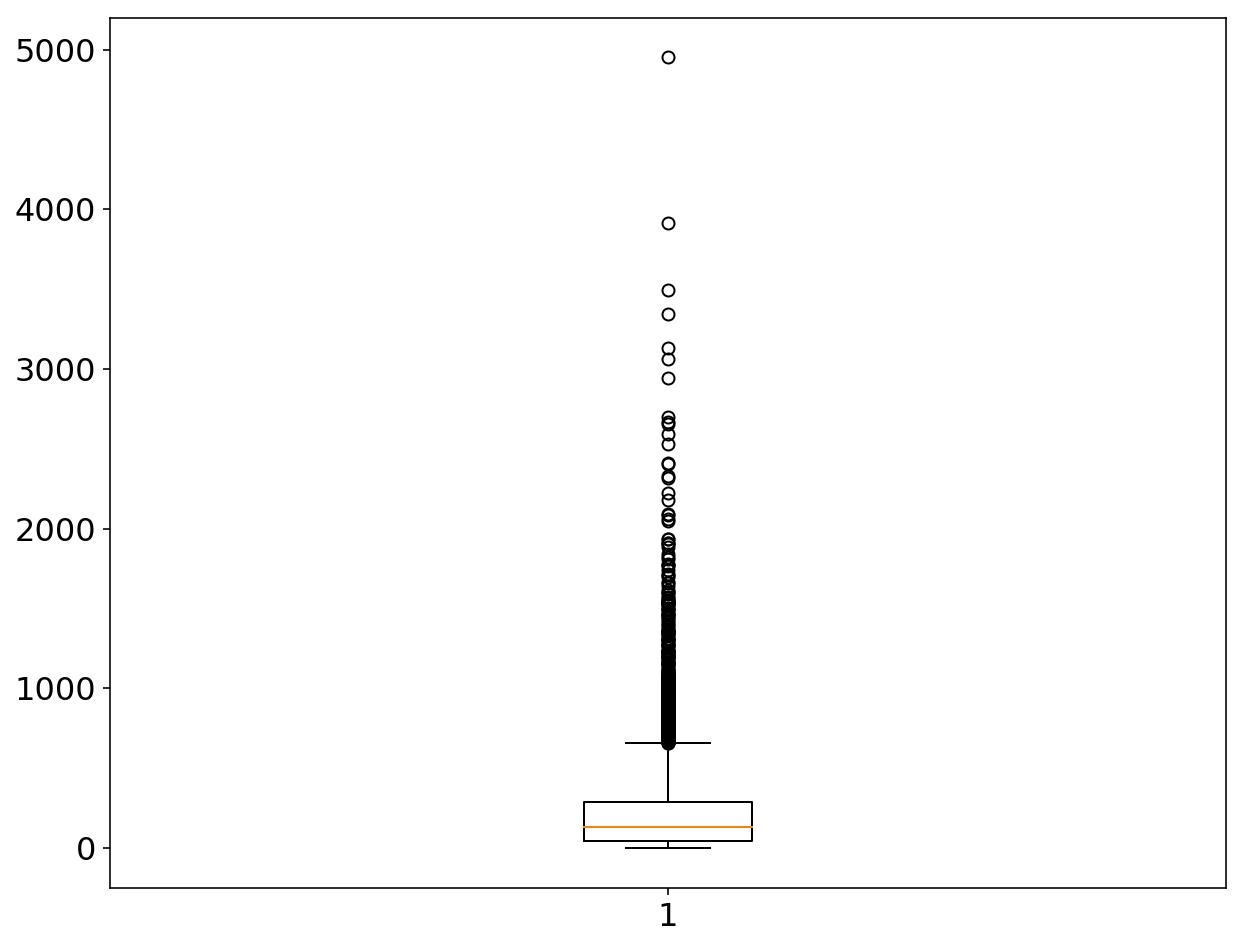

In [17]:
# Box plot of death time in hours since ICU admission
matplotlib.rcParams.update({'font.size': 16})
fig = plt.figure()
fig.set_size_inches(10,8)
plt.boxplot(dead_patients.hosp_deathtime_hours.tolist())
fig.savefig('./img/figure1.png')
plt.show()

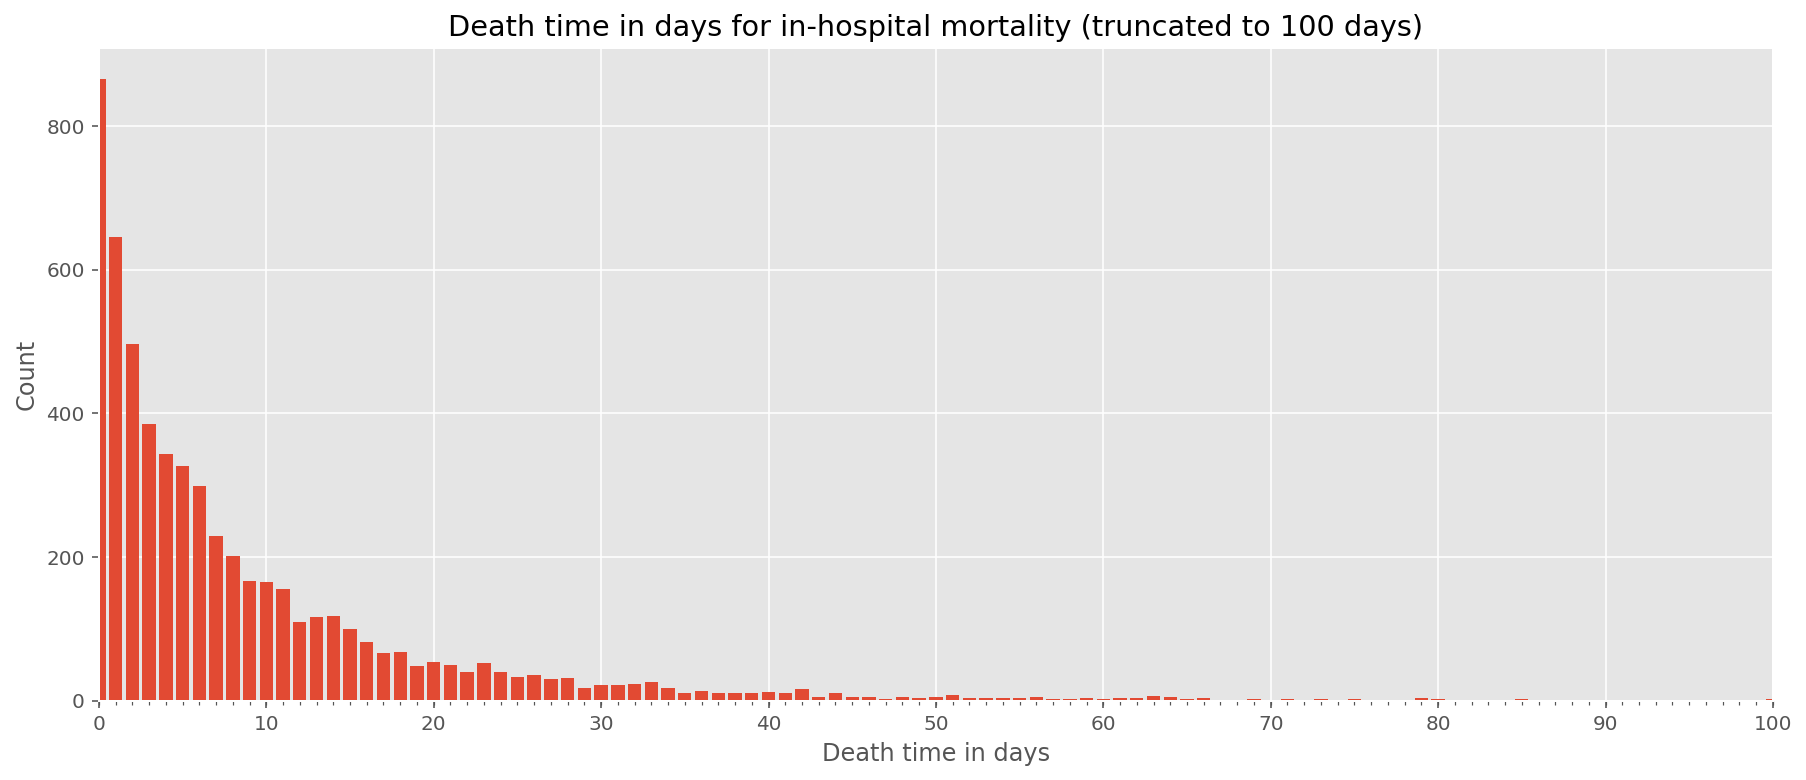

In [18]:
# Histogram of death time in days since ICU admission
plt.style.use('ggplot')
fig = plt.figure()
fig.set_size_inches(15,6)
ax = plt.axes()
ax.set_xlim(0, 100)
ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(1))

data = (dead_patients[['icustay_id','hosp_deathtime_hours']]/24).astype(int)
data = data.groupby('hosp_deathtime_hours').size()
plt.bar(data.index, data, align='center')
plt.xlabel('Death time in days')
plt.ylabel('Count')
plt.title('Death time in days for in-hospital mortality (truncated to 100 days)')
fig.savefig('./img/figure2.png')
plt.show()

In [19]:
# class label distribution of death time in hours
cutoff1 = 24
cutoff2 = 24*7
print('Cutoff hours: ', cutoff1, 'hours and', cutoff2, 'hours')
print('Class 0 size', len([x for x in dead_patients.hosp_deathtime_hours.tolist() if x < cutoff1]))
print('Class 1 size', len([x for x in dead_patients.hosp_deathtime_hours.tolist() if cutoff1 <= x < cutoff2]))
print('Class 2 size', len([x for x in dead_patients.hosp_deathtime_hours.tolist() if x >= cutoff2]))

Cutoff hours:  24 hours and 168 hours
Class 0 size 865
Class 1 size 2496
Class 2 size 2354
